# Final Project Submission
## Please fill out:

* Student name: Nastaran Nazemian
* Student pace: part time
* Scheduled project review date/time: 28/4/2020 1:30PM (PS)
* Instructor name: Eli Thomas
* Blog post URL:?????????????

# Overview
After data mining, the next step is to clean collected data. For this, I wrote new functions and used existing ones to change the columns’ datatype, find the outliers and the missing data. Finally, based on the this, I found and implemented the correct method for estimating missing data and eliminating the outliers. I save the final data frame to a JSON file to use in the next step.

In [1]:
import re
import numpy as np
import pandas as pd
import math
import json
from scipy import stats
import collections
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#loading the Dataset
def load_data():
    data = pd.read_json (r'C:\Flatiron\course-material\ModuleOneFinalProject\dsc-mod-1-project-v2-1-onl01-dtsc-pt-030220\data_0423_0749PM_30pages_2010_2020.json')
    return pd.DataFrame(data)

In [3]:
#Creat a List of the Columns Should Conver to the Float.
int_columns = ['Budget','Gross USA', 'Cumulative Worldwide Gross', 'Popularity',
                'Opening Weekend USA', 'Rating_count',
                'Meta_Score', 'User_Review_Number', 'Critical_Review_Number']
#Convert a Column to Float
def to_numeric(df):
    df[int_columns] = df[int_columns].apply(pd.to_numeric, errors='coerce')
    return df
#df = to_numeric(df)
#df.info()

Since I scraped my data, I need to change my columns’ format. To solve this problem, I had to open the data. One of the problems I encountered was having multiple genres for some of the movies. To solve this problem, I had to flatten my dataset. For example, for a film that has three genres, the dataset must have three rows. Function `flatten_genre(df)` creates a flattened dataset. 

In [4]:
def flatten_genre(df):
 
    flatten_df = df['Genre'].apply(pd.Series) \
        .merge(df, right_index = True, left_index = True) \
        .drop(['Genre'], axis = 1) \
        .melt(id_vars = df.columns.drop('Genre'), value_name = "Genre") \
        .drop("variable", axis = 1) \
        .dropna(subset=['Genre'])
    
    return flatten_df


In [5]:
def get_all_genres_count(flatten_df):
    return flatten_df.groupby('Genre')['Genre'].count()

In [6]:
def budget_hist(df, col_name):
    non_miss_Budegets = df[col_name].loc[df[col_name] > 0]
    non_miss_Budegets.isna().sum()
    display(non_miss_Budegets.apply(['mean', 'median', 'std']))
    non_miss_Budegets.hist()
#budget_hist(df, 'Budget')

Since the movie budget depends on the genre, I decided to use weighted mean for estimating the missing data. For genre weight, I used the frequency of each genre over the number of all genres which exists in my flatten data set.

In [7]:
def get_genres_weight(all_genres_count, flatten_df):
    return all_genres_count / len(flatten_df)

Before estimating the missing data, the outliers should be taken out, because they would directly effect the weighted mean. Here are two ways for taking out outliers. 

In [8]:
# def remove_outlier(df, col_name):
#     q1 = df[col_name].quantile(0.25)
#     q3 = df[col_name].quantile(0.75)
#     iqr = q3-q1 #Interquartile range
#     fence_low  = q1-1.5*iqr
#     fence_high = q3+1.5*iqr
#     df_out = df.loc[(df[col_name] > fence_low) & (df[col_name] < fence_high)]
#     return df_out
def remove_outlier(df, col_name):    
# df[(np.abs(stats.zscore(df)) < 3).any(axis=1)]
    df_out = df[(np.abs(stats.zscore(df[col_name], nan_policy='omit')) < 3)]
    return df_out


In [9]:
#Get Mean and Median a Column After Removing the Outliers
def get_per_column_stat(flatten_df, column, group_by_column):
    no_outlier_df = remove_outlier(flatten_df, column)
    return no_outlier_df.groupby(group_by_column).agg({column: ['mean', 'median']})


In [10]:
#Estimate missing values based on the Weighted Mean
def estimate_missing_column(df, per_column_stat, genres_weight, column_name):
    for index, genres in enumerate(df['Genre']):
        if math.isnan(df[column_name][index]) :
            weight_sum = 0
            weighted_mean = 0
            for movie_genre in genres:
                if (movie_genre in per_column_stat[column_name]['mean']):
                    weight_sum += genres_weight[movie_genre]
                    weighted_mean += \
                            per_column_stat[column_name]['mean'][movie_genre] * \
                            genres_weight[movie_genre]
            df.iloc[index, df.columns.get_loc(column_name)] = weighted_mean / weight_sum
    return df



In [11]:

def get_ready_to_analyze_data():
    df = load_data()
    df = to_numeric(df)
    flatten_df = flatten_genre(df)
    all_genres_count = get_all_genres_count(flatten_df)
    genres_weight = get_genres_weight(all_genres_count, flatten_df)
    for column in ['Budget','Runtime_min', 'User_Review_Number','Critical_Review_Number']:
        per_column_stat = get_per_column_stat(flatten_df, column, 'Genre')
        df = estimate_missing_column(df, per_column_stat, genres_weight, column)
    return df

ready_to_analyze_data = get_ready_to_analyze_data()
ready_to_analyze_data.isna().sum()



C:\Users\Nastaran\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


Title_id                        0
Budget                          0
Gross USA                     241
Cumulative Worldwide Gross    137
Opening Weekend USA           254
Title                           7
Year                            0
Popularity                      0
Genre                           0
Runtime_min                     0
Release_day                     5
IMDB_Rate                       1
Rating_count                    1
Meta_Score                    895
Director                        0
Writer                          0
Star                            0
User_Review_Number              0
Critical_Review_Number          0
Meta_Rating                     0
dtype: int64

In [57]:
New_df = ready_to_analyze_data.dropna(subset=['Title', 'Release_day','IMDB_Rate', 'Rating_count','Gross USA', 'Cumulative Worldwide Gross'])
New_df.isna().sum()


Title_id                        0
Budget                          0
Gross USA                       0
Cumulative Worldwide Gross      0
Opening Weekend USA            13
Title                           0
Year                            0
Popularity                      0
Genre                           0
Runtime_min                     0
Release_day                     0
IMDB_Rate                       0
Rating_count                    0
Meta_Score                    737
Director                        0
Writer                          0
Star                            0
User_Review_Number              0
Critical_Review_Number          0
Meta_Rating                     0
dtype: int64

In [13]:
New_df.drop(['Meta_Score'], axis = 1, inplace=True)
New_df = remove_outlier(New_df, 'Budget')

C:\Users\Nastaran\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
New_df.isna().sum()
New_df.shape

(1234, 19)

In [15]:
New_df.head()

,Title_id,Budget,Gross USA,Cumulative Worldwide Gross,Opening Weekend USA,Title,Year,Popularity,Genre,Runtime_min,Release_day,IMDB_Rate,Rating_count,Director,Writer,Star,User_Review_Number,Critical_Review_Number,Meta_Rating
0,tt8367814,22000000.0,36296853.0,114996853.0,10651884.0,The Gentlemen,2019,6,"[Action, Comedy, Crime]",113.0,01/24/2020,8.0,111609.0,[Guy Ritchie],"[Guy Ritchie, Ivan Atkinson]","[Matthew McConaughey, Charlie Hunnam, Michelle...",867.0,231.0,R
1,tt7131622,90000000.0,142502728.0,374343626.0,41082018.0,Once Upon a Time... in Hollywood,2019,8,"[Comedy, Drama]",161.0,07/26/2019,7.7,445375.0,[Quentin Tarantino],[Quentin Tarantino],"[Leonardo DiCaprio, Brad Pitt, Margot Robbie]",4811.0,594.0,R
2,tt8946378,40000000.0,165363234.0,309232797.0,26769548.0,Knives Out,2019,10,"[Comedy, Crime, Drama, Mystery, Thriller]",131.0,11/27/2019,7.9,279415.0,[Rian Johnson],[Rian Johnson],"[Daniel Craig, Chris Evans, Ana de Armas]",1822.0,417.0,PG-13
3,tt8579674,95000000.0,159227644.0,368027644.0,576216.0,1917,2019,13,"[Drama, War]",119.0,01/10/2020,8.3,285906.0,[Sam Mendes],"[Sam Mendes, Krysty Wilson-Cairns]","[Dean-Charles Chapman, George MacKay, Daniel M...",2465.0,447.0,R
4,tt1598778,60000000.0,75658097.0,136515867.0,22403596.0,Contagion,2011,15,"[Action, Drama, Thriller]",106.0,09/09/2011,6.7,257205.0,[Steven Soderbergh],[Scott Z. Burns],"[Matt Damon, Kate Winslet, Jude Law]",684.0,255.0,PG-13


In [16]:
New_df.to_json('clean1_data.json')

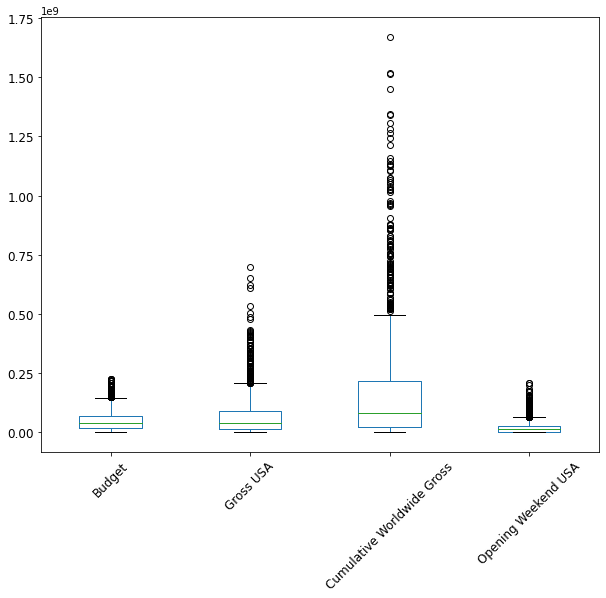

In [55]:
df = New_df

# f, ax = plt.subplots(figsize=(15,9))
# sns.boxplot(data = df.iloc[:,1:5])
columns = ['Budget','Gross USA', 'Cumulative Worldwide Gross', 'Opening Weekend USA', ]
boxplot = df.boxplot(column=columns, grid=False, rot=45, fontsize=12, figsize = (10,8))
